In [2]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import configparser
from pathlib import Path
from scipy import interpolate
from scipy.stats import gaussian_kde

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('../_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        # tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Load saved data

In [3]:
# parent_folder = Path(results_dir,'experiment_nonlinear')
parent_folder = Path(results_dir,'experiment_linear_mdae')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

/bin/bash: /home/ym917/miniconda3/envs/MD-CNN-AE/lib/libtinfo.so.6: no version information available (required by /bin/bash)
linear_mdae1-3572256  linear_mdae3-3572258  linear_mdae5-3572260
linear_mdae2-3572257  linear_mdae4-3572259


In [26]:
# folder = '0808_2mode9-2255817'
# folder = '0808_2mode5-2894762'
folder = 'linear_mdae4-3572259'
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
mdl_config = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.4790945


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.
MSE reconstructed with 2 modes is:  1.4777343273162842


/home/ym917/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


Calculating POD ...
User has selected classic POD
POD done.


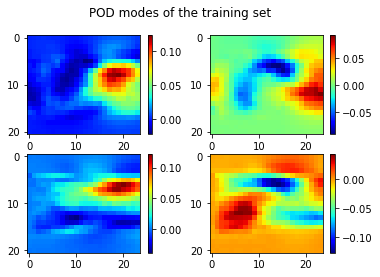

In [27]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
pod_test = md.POD(X_test,method='classic')
A_test = pod_test.get_time_coefficient
Q_POD_test, lam_data_test = pod_test.get_modes

plt.show()

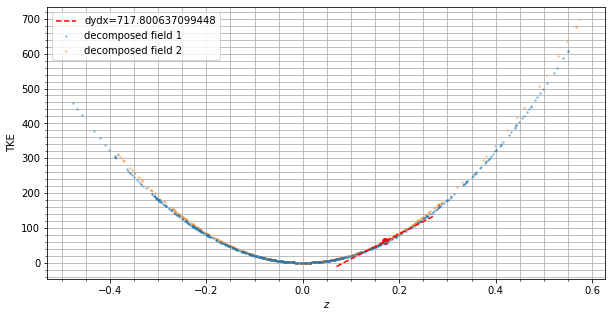

correlation coefficient 0.9999999999662301


In [28]:
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)

plt.figure(figsize=(10,5))
plt.scatter(latent_test[:,0], ke[0,:], alpha=0.4,label='decomposed field 1',s=2,zorder=2)
plt.scatter(latent_test[:,1], ke[1,:], alpha=0.4,label='decomposed field 2',s=2)
plt.xlabel('$z$')
plt.ylabel('TKE')
# plt.xlim([-0.01,0.15])
plt.minorticks_on()
plt.grid(which='both')
# plt.vlines(0.18,ymin=0.0001,ymax=500,linestyles='--',color='k')


### tangent
sort_idx = np.argsort(latent_test[:,1])
x_tan = latent_test[:,1][sort_idx]
y_tan = ke[1,:][sort_idx]
tck = interpolate.splrep(x_tan,y_tan)
x0 = 0.17
y0 = interpolate.splev(x0,tck)
dydx = interpolate.splev(x0,tck,der=1)
plt.scatter(x0,y0,c='r')
plot_tangent = np.linspace(x0-0.1,x0+0.1,50)
tngnt = lambda x: dydx*x + (y0-dydx*x0)
plt.plot(plot_tangent,tngnt(plot_tangent),'r--',label=f'dydx={dydx}')


plt.legend()
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(latent_test[:,0]**2), ke[0,:])[0,1])

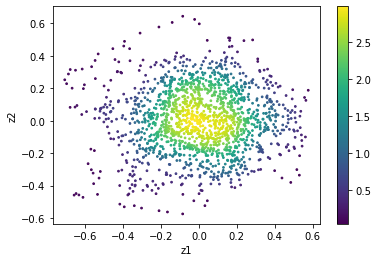

In [29]:
v1 = latent_train[:,0]
v2 = latent_train[:,1]
values = np.vstack([v1,v2])
kde = gaussian_kde(values)(values)
plt.figure()
plt.scatter(v1,v2,c=kde,s=3)
plt.xlabel('z1')
plt.ylabel('z2')
plt.colorbar()
plt.show()

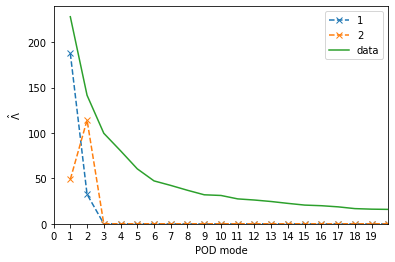

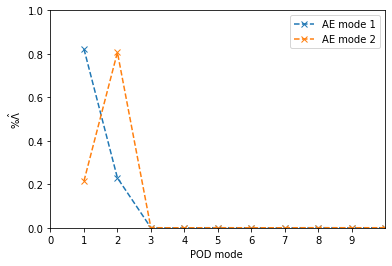

In [30]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
lam_modes_percent = lam_modes/lam_data
x_axis = np.arange(1,mdl_config.Nz*mdl_config.Ny*mdl_config.Nu+1)

plt.figure()
for i in range(mdl_config.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('$\hat{\Lambda}$')
plt.xlabel('POD mode')
plt.legend()

plt.figure()
for i in range(mdl_config.latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:],label='AE mode '+str(i+1),linestyle='--',marker='x')
plt.xlim([0,10])
plt.ylim([0,1])
plt.xticks(range(10))
plt.legend()
plt.xlabel('POD mode ')
plt.ylabel('$\% \hat{\Lambda}$')
# plt.title('precentage of POD modes captured')


A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5


plt.show()

In [ ]:
print(modes_train.shape,Q_POD.shape) 

# Coefficients of decomposed fields

## Post process decomposed fields

In [ ]:
ntrain = modes_train.shape[1]
x_train = einsum('k t y z u -> k y z t u', modes_train)
B = []
for i in range(modes_train.shape[0]):
    X_train = np.vstack((x_train[i,:,:,:,0], x_train[i,:,:,:,1]))
    X_train = np.reshape(X_train,(-1, ntrain))
    b = einsum('x t, x m -> t m', X_train, Q_POD)
    B.append(b)
B = np.array(B) # [latent_dim, time, number of pod modes]

### decoder 1

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Decomposed field 1, coefficients for POD modes')
for i in range(5):
    plt.scatter(latent_train[:,0], B[0,:,i], alpha=0.8,label=f'$b_1,_{i+1}$',s=2)
plt.legend()
plt.grid()
plt.xlabel('$z_1$')
plt.ylabel('b')
plt.show()

# fig, ax = myplot.scatter_matrix(B[0,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_hist={'color':'b'})

In [ ]:
# i = 0
# degree = 1
# fn = np.polynomial.polynomial.Polynomial.fit(latent_train[:,0],B[0,:,i],degree)
# fn_coeff = fn.convert().coef
# fitted = np.polynomial.polynomial.polyval(latent_train[:,0],fn_coeff)
# fig = plt.figure(figsize=(10,10))
# plt.scatter(latent_train[:,0],B[0,:,i],label=f'$b_1,_{i+1}$')
# plt.scatter(latent_train[:,0],fitted,label=f'fitted {degree}th polynomial',s=2)
# plt.legend()
# plt.show()

### decoder 2

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Decomposed field 2, coefficients for POD modes')
for i in range(5):
    plt.scatter(latent_train[:,1], B[1,:,i], alpha=0.8,label=f'$b_2,_{i+1}$',s=2)
plt.legend()
plt.xlabel('$z_2$')
plt.ylabel('b')
plt.grid()
plt.show()

# fig, ax = myplot.scatter_matrix(B[1,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_hist={'color':'b'})

In [ ]:
### fit polynomial
# i = 0
# degree = 1
# w = 1/(B[1,:,i]+1)
# idx = np.argsort(latent_train[:,1])
# fn = np.polynomial.polynomial.Polynomial.fit(latent_train[:,1][idx],B[1,:,i][idx],degree)
# fn_coeff = fn.convert().coef
# fitted = np.polynomial.polynomial.polyval(latent_train[:,1],fn_coeff)
# fig = plt.figure(figsize=(10,10))
# plt.scatter(latent_train[:,1],B[1,:,i],label=f'$b_2,_{i+1}$')
# plt.scatter(latent_train[:,1],fitted,label=f'fitted {degree}th polynomial',s=2)
# plt.legend()
# plt.show()
# print(fn_coeff)

In [ ]:
## total output
# # B [latent_dim, time, POD modes]
# B_total = np.sum(B,axis=0)
# fig, ax = myplot.scatter_matrix(B_total[:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})

### error

In [ ]:
err = u_train - np.sum(modes_train,axis=0)
x_err = einsum('k t y z u -> k y z t u', err)
B_err = []
for i in range(err.shape[0]):
    X_err = np.vstack((x_err[i,:,:,:,0], x_err[i,:,:,:,1]))
    X_err = np.reshape(X_err,(-1, ntrain))
    b = einsum('x t, x m -> t m', X_err, Q_POD)
    B_err.append(b)
B_err = np.array(B_err) # [latent_dim, time, number of pod modes]

In [ ]:
fig, ax = myplot.scatter_matrix(B_err[0,:,:5],['b1','b2','b3','b4','b5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})
fig.suptitle('Error')
plt.show()

In [ ]:
v1 = B_err[0,:,0]
v2 = B_err[0,:,2]
values = np.vstack([v1,v2])
kde = gaussian_kde(values)(values)
plt.figure()
plt.scatter(v1,v2,c=kde,s=3)
# plt.colorbar()
plt.show()

In [ ]:
B_total_with_err = np.sum(B,axis=0) + np.squeeze(B_err)
print("Is the sum of all b's A")
print(np.allclose(A,B_total_with_err,atol=10e-5))

## From gradients

In [31]:
from MD_AE_tools.models import model_evaluation
from tensorflow.keras.optimizers import Adam

In [32]:
mdl = mdl_nobias.MD_Autoencoder(Nx=mdl_config.Nx,Nu=mdl_config.Nu,
                            features_layers=mdl_config.features_layers,
                            latent_dim=mdl_config.latent_dim,
                            filter_window=mdl_config.filter_window,
                            act_fct=mdl_config.act_fct,
                            batch_norm=mdl_config.BATCH_NORM,
                            drop_rate=mdl_config.drop_rate,
                            lmb=mdl_config.lmb,
                            resize_meth=mdl_config.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=mdl_config.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ===============================================
decoders = mdl.get_decoders()

51/51 [==============================] - 0s 7ms/step - loss: 1.4791


In [33]:
z = np.linspace(-0.8,0.8,2001).astype('float32')
steps = len(z)
print(steps)
print(np.argwhere(np.abs(z-0)<1.19209e-07))

2001
[[1000]]


In [34]:
#### Compute derivatives in batches
batch_size = 60
dy_dz = []
for i in range(mdl_config.latent_dim):
    t = 0
    dy_dz_i = []
    while (t+batch_size) < steps:
    # for t in range(steps):
        gradients = model_evaluation.get_gradient_m_z(tf.reshape(z[t:t+batch_size],(-1,1)),decoders[i]) ## get gradients
        dyt_dzt = gradients[:,:,:,:,0] ## keep only the relavent gradient
        dy_dz_i.append(dyt_dzt)
        t = t + batch_size
    
    gradients = model_evaluation.get_gradient_m_z(tf.reshape(z[t:],(-1,1)),decoders[i]) ## get gradients
    dyt_dzt = gradients[:,:,:,:,0] ## keep only the relavent gradient
    dy_dz_i.append(dyt_dzt)
    # dy_dz_i = np.stack(dy_dz_i)
    
    dy_dz.append(np.vstack(dy_dz_i))

dy_dz = np.array(dy_dz)

In [35]:
dy_dz_vector = []
dy_dz_temp = einsum('k t y z u -> k y z t u', dy_dz)
for i in range(mdl_config.latent_dim):
    dy_dz_reshape = np.vstack((dy_dz_temp[i,:,:,:,0], dy_dz_temp[i,:,:,:,1]))
    dy_dz_reshape = np.reshape(dy_dz_reshape,(-1, steps))
    dy_dz_vector.append(dy_dz_reshape)
dy_dz_vector = np.array(dy_dz_vector)

In [36]:
dB1_dz = Q_POD.T @ dy_dz_vector[0,...]
dB2_dz = Q_POD.T @ dy_dz_vector[1,...]
print(dB1_dz.shape)

(1008, 2001)


In [37]:
B1_g = []
B2_g = []
for i in range(10):
    B1_g.append(
        model_evaluation.one_step_integrate(z,dB1_dz[i,:],0,0,z[1]-z[0])
    )
    B2_g.append(
        model_evaluation.one_step_integrate(z,dB2_dz[i,:],0,0,z[1]-z[0])
    )

### Plots

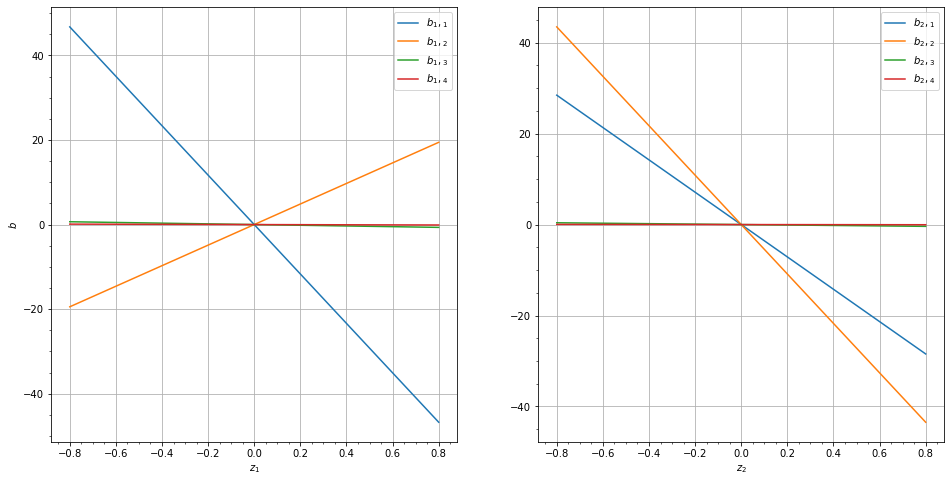

In [39]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
# fig.suptitle('B from gradients')
for i in range(4):
    ax[0].plot(z,B1_g[i],label=f'$b_1,_{i+1}$')
    ax[1].plot(z,B2_g[i],label=f'$b_2,_{i+1}$')
ax[0].minorticks_on()
ax[0].grid('both')
ax[1].minorticks_on()
ax[1].grid('both')
ax[0].set_ylabel('$b$')
ax[0].set_xlabel('$z_1$')
ax[1].set_xlabel('$z_2$')
ax[0].legend()
ax[1].legend()
# fig.savefig('coeff_linear.pdf')
plt.show()


## Compare two methods

NameError: name 'B' is not defined

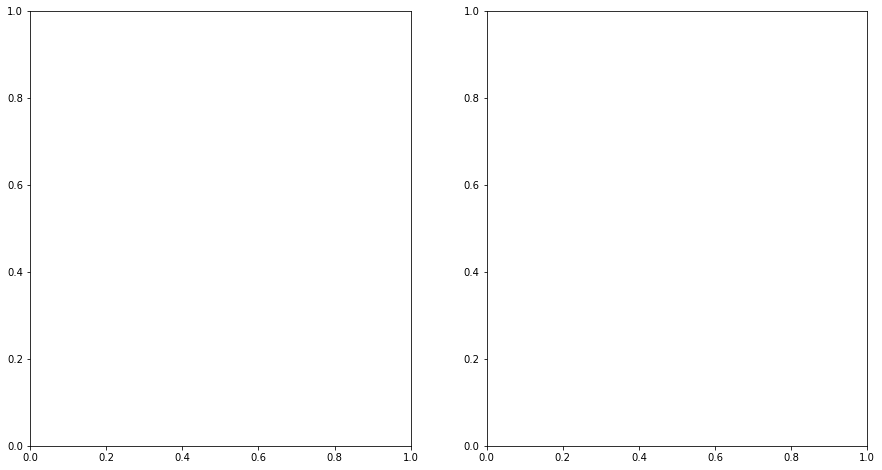

In [14]:
cmap = plt.cm.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, 20))

fig, ax = plt.subplots(1,2,figsize=(15,8))
for i in range(5):
    ax[0].scatter(latent_train[:,0], B[0,:,i],label=f'post processing $b_1,_{i+1}$',s=10,color=colors[2*i+1],facecolor='none',zorder=1)
    ax[0].plot(z,B1_g[i],color=colors[2*i],linestyle='--',zorder=2,label=f'gradient $b_1,_{i+1}$')
    ax[1].scatter(latent_train[:,1], B[1,:,i],label=f'post processing $b_2,_{i+1}$',s=10,color=colors[2*i+1],facecolor='none',zorder=1)
    ax[1].plot(z,B2_g[i],color=colors[2*i],linestyle='--',zorder=2,label=f'gradient $b_2,_{i+1}$')
ax[0].set(title='decomposed field 1',xlabel='z1',ylabel='b1,')
ax[1].set(title='decomposed field 2',xlabel='z2',ylabel='b2,')
ax[0].grid()
ax[1].grid()
ax[0].legend(ncol=2)
ax[1].legend(ncol=2)
plt.show()



# fig = plt.figure(figsize=(15,15))
# for i in range(5):
#     plt.scatter(latent_train[:,0], B[0,:,i],label=f'post processing $b_1,_{i+1}$',s=10,color=colors[2*i+1],facecolor='none',zorder=1)
#     plt.plot(z,B1_g[i],color=colors[2*i],linestyle='--',zorder=2,label=f'gradient $b_1,_{i+1}$')
# plt.title('decomposed field 1')
# plt.ylabel('b1,')
# plt.xlabel('z1')
# plt.legend(ncol=2)# can add columns
# plt.grid()
# plt.show()

# Data

In [ ]:
v1 = A[:,1]
v2 = A[:,2]
values = np.vstack([v1,v2])
kde = gaussian_kde(values)(values)
plt.figure()
plt.scatter(v1,v2,c=kde,s=3)
plt.xlabel('a2')
plt.ylabel('a3')
plt.axis('equal')
# plt.colorbar()
plt.show()

In [ ]:
fig, ax = myplot.scatter_matrix(A[:,:5],['a1','a2','a3','a4','a5'],kwargs_figure={'figsize':(10,10)},kwargs_scatter={'s':2},kwargs_hist={'color':'b'})

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(A_test[:,0],label='a1')
plt.plot(A_test[:,1],label='a2')
plt.plot(A_test[:,2],label='a3')
plt.legend()
plt.xlabel('t')
plt.ylabel('a')
plt.show()

In [ ]:
plt.plot(latent_test[:,0])
plt.plot(latent_test[:,1])